# <span style="font-family:cursive;text-align:center">⬇️ Import Libraries</span>

In [58]:
import os
import warnings
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
from scipy.signal import spectrogram


warnings.filterwarnings('ignore')

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
&nbsp;<b>The function create_spectrogram takes an input audio file path and generates a spectrogram image, saving it to the specified image file path. It utilizes the librosa library to load the audio, compute its mel spectrogram, and convert the power spectrogram to a decibel scale for better visualization.</b><br>
<br>
&nbsp;<b>The create_pngs_from_wavs function automates the process for multiple audio files within a given directory. It converts all .wav files in the specified input directory into spectrogram images, saving the resulting images to the designated output directory. This function makes use of the create_spectrogram function internally to generate the spectrogram images.

# <span style="font-family:cursive;text-align:center">📊 Data Processing and Training set generation</span>

In [59]:
def generate_spectrogram(audio_file, image_file):
    # Read the audio file
    sample_rate, audio_data = wav.read(audio_file)

    # Compute the spectrogram
    frequencies, times, spectrogram_data = spectrogram(audio_data, sample_rate)

    # Plot the spectrogram
    plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram_data), shading='auto')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.colorbar(label='Intensity [dB]')
    plt.title('Spectrogram')

    # Save the spectrogram as an image file
    plt.savefig(image_file)
    plt.close()


def convert_wav_to_spectrogram(input_path, output_path):
    # Create the output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Iterate over .wav files in the input directory
    for filename in os.listdir(input_path):
        if filename.endswith('.wav'):
            # Construct the input and output file paths
            input_file = os.path.join(input_path, filename)
            output_file = os.path.join(output_path, os.path.splitext(filename)[0] + '.png')

            # Generate and save the spectrogram
            generate_spectrogram(input_file, output_file)

In [60]:
convert_wav_to_spectrogram('/content/donateacry_corpus/belly_pain', '/content/working3/belly_pain')
convert_wav_to_spectrogram('/content/donateacry_corpus/burping', '/content/working3/burping')
convert_wav_to_spectrogram('/content/donateacry_corpus/discomfort', '/content/working3/discomfort')
convert_wav_to_spectrogram('/content/donateacry_corpus/hungry', '/content/working3/hungry')
convert_wav_to_spectrogram('/content/donateacry_corpus/tired', '/content/working3/tired')

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    &nbsp;<b>Loading the images from the path</b><br>
</div>

In [61]:
x = []
y = []

from keras.preprocessing import image

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))

    return images, labels

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
     &nbsp;<b>The function takes in source patterns and their corresponding destination paths as input. If the destination directory doesn't exist, it creates the directory and proceeds with moving the files. It utilizes the glob module to identify the files based on the specified patterns and shutil for the file movement.
</b><br>
    <br>
    &nbsp;<b>With this we create the training dataset and leave a file for each type for testing</b><br>
</div>

In [62]:
import glob
import shutil

def move_files(source_pattern, destination_path):
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)
        print(f"Directory '{destination_path}' created successfully.")
    else:
        print(f"Directory '{destination_path}' already exists.")

    files_to_move = glob.glob(source_pattern)
    for file_path in files_to_move[:-1]:
        shutil.move(file_path, destination_path)

# Define your directories and source patterns
directories = {
    '/content/working3/belly_pain_train/': '/content/working3/belly_pain/*.png',
    '/content/working3/burping_train/': '/content/working3/burping/*.png',
    '/content/working3/discomfort_train/': '/content/working3/discomfort/*.png',
    '/content/working3/hungry_train/': '/content/working3/hungry/*.png',
    '/content/working3/tired_train/': '/content/working3/tired/*.png'
}

# Loop through the directories and move the files
for directory, source_pattern in directories.items():
    move_files(source_pattern, directory)

Directory '/content/working3/belly_pain_train/' created successfully.
Directory '/content/working3/burping_train/' created successfully.
Directory '/content/working3/discomfort_train/' created successfully.
Directory '/content/working3/hungry_train/' created successfully.
Directory '/content/working3/tired_train/' created successfully.


In [63]:
images, labels = load_images_from_path('/content/working3/belly_pain_train', 0)

x += images
y += labels

images, labels = load_images_from_path('/content/working3/burping_train', 1)

x += images
y += labels

images, labels = load_images_from_path('/content/working3/discomfort_train', 2)

x += images
y += labels

images, labels = load_images_from_path('/content/working3/hungry_train', 3)

x += images
y += labels

images, labels = load_images_from_path('/content/working3/tired_train', 4)

x += images
y += labels

In [65]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# <span style="font-family:cursive;text-align:center">⚙️ Model Training</span>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Model Architecture:</font></h3>
    
1. **Input Layer**: Accepts input images of shape (224, 224, 3), which corresponds to images with a height and width of 224 pixels and three color channels (RGB).
2. **Resizing Layer: Resizes the input images to a smaller size of (64, 64). This reduction in image dimensions may help speed up training.
3. **Normalization Layer**: Normalizes pixel values to have zero mean and unit variance, which aids in stabilizing and speeding up the training process.
4. **Convolutional Layers**: Utilizes two convolutional layers:
     - The first convolutional layer has 64 filters, a kernel size of 3x3, and ReLU activation.
     - The second convolutional layer has 128 filters, a kernel size of 3x3, and ReLU activation.
7. **MaxPooling Layer**: Performs max pooling with a pool size of 2x2, reducing the spatial dimensions of the feature maps.
8. **Dropout Layer**: Introduces a dropout rate of 20% to prevent overfitting by randomly deactivating a fraction of neurons during training.
9. **Flatten Layer**: Flattens the 2D feature maps into a 1D vector to prepare for the fully connected layers.
10. **RandomFourierFeatures Layer**: Incorporates random Fourier features with 5 components, which can approximate non-linear mappings efficiently for the data.
11. **Compilation**: Compiles the model using the AdamW optimizer with a learning rate of 0.01, categorical cross-entropy loss function (suitable for multi-class classification), and accuracy as the evaluation metric.

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout,Normalization,Resizing,InputLayer
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from tensorflow.keras.optimizers import Adam,Adafactor,AdamW,Lion
from tensorflow.keras.optimizers.experimental import Adadelta,Adagrad,Adamax,RMSprop,SGD,Nadam,Ftrl

model = Sequential()
model.add(InputLayer(input_shape=(224, 224, 3)))
model.add(Resizing(64,64))
model.add(Normalization())
model.add(Conv2D(64, 3, strides=1, activation='relu'))
model.add(Conv2D(128, 3, strides=1, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(RandomFourierFeatures(5))
model.compile(optimizer=AdamW(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_9 (Resizing)       (None, 64, 64, 3)         0         
                                                                 
 normalization_9 (Normaliza  (None, 64, 64, 3)         7         
 tion)                                                           
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 30, 30, 128)      

Epoch 1/50
12/12 [==============================] - 2s 67ms/step - loss: 10.0877 - accuracy: 0.4626 - val_loss: 14.9068 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 1s 43ms/step - loss: 14.2632 - accuracy: 0.7507 - val_loss: 14.8782 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 0s 34ms/step - loss: 14.2010 - accuracy: 0.4681 - val_loss: 14.8782 - val_accuracy: 0.2088 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 0s 32ms/step - loss: 13.6626 - accuracy: 0.4515 - val_loss: 14.8782 - val_accuracy: 0.4835 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 0s 32ms/step - loss: 13.2609 - accuracy: 0.4958 - val_loss: 14.8782 - val_accuracy: 0.0659 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 0s 33ms/step - loss: 12.3676 - accuracy: 0.4127 - val_loss: 14.8782 - val_accuracy: 0.0659 - lr: 0.0010
Epoch 7/50
12/12 [==============================] - 0s 32ms/step

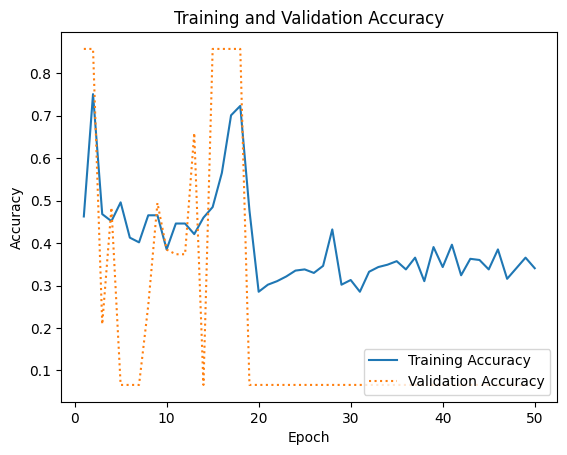

In [67]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=2,
                              min_lr=0.006,
                              verbose=1)

hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), epochs=50,callbacks=[reduce_lr])

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()
plt.show()

# <span style="font-family:cursive;text-align:center">🧪 Testing</span>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    &nbsp;<b>For predicting on single tets files this code will be used. For each image file path obtained, the code performs the following operations:

- Loads the image using image.load_img() from the Keras preprocessing module, resizing it to the required dimensions of 224x224 pixels.
- Converts the image to a format compatible with the model for prediction (image.img_to_array() and np.expand_dims()).
- Utilizes the model for prediction on the image
- Retrieves class labels corresponding to the categories ('belly pain', 'burping', 'discomfort', 'hungry', 'tired').
- Prints the original file path and its predicted category, appending this information to the results list.</b>
</div>

In [69]:
import glob
import os

def get_png_files(directory):
    folders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']
    png_files = []

    for folder_name in folders:
        folder_path = os.path.join(directory, folder_name)
        if os.path.exists(folder_path):
            png_files.extend(glob.glob(os.path.join(folder_path, '*.png')))
        else:
            print(f"Folder '{folder_name}' does not exist in '{directory}'.")

    return png_files

directory_path = '/content/working3/'
png_files_list = get_png_files(directory_path)

results = []
for file_path in png_files_list:
    x = image.load_img(file_path, target_size=(224, 224))

    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)

    y = model.predict(x)

    class_labels = ['belly pain','burping','discomfort','hungry','tired']

    # for i, label in enumerate(class_labels):
    #     print(f'{label}: {y[0][i]}')

    results.append(f"Original:{file_path.split('/')[3]} Predicted: {class_labels[np.argmax(y)]}")

print('\n')

for i in results:
    print(i)
    print('\n')

1/1 [==============================] - 0s 17ms/step


Original:belly_pain Predicted: belly pain


Original:burping Predicted: discomfort


Original:discomfort Predicted: tired


Original:hungry Predicted: burping


Original:tired Predicted: belly pain


